# La edad de un cliente desde una fotografía

## Índice

* [Introducción](#intro)
* [Etapa 1. Descripción y preprocesamiento de los datos](#data_review)
    * [Información general de los datos](#data_review_data)
    * [Conclusiones](#data_review_conclusions)
* [Etapa 2. Análisis de datos](#data_analysis)
    * [Conclusiones](#data_analysis_conclusions)
* [Etapa 3. Entrenamiendo del modelo](#data_model)
    * [Creación de funciones](#data_model_functions)
    * [Resultados del entrenamiento](#data_model_train)
    * [Conclusiones](#data_model_conclusions)
* [Conclusión general](#data_conclusion)


## Introducción <a id='intro'></a>

La cadena de supermercados Good Seed debe asegurarse de no vender alcohol a menores de edad y cumplir con la normativa. Por lo que el objetivo de este proyecto es construir y evaluar un modelo para verificar la edad de las personas. Se cuenta con un conjunto de fotografías de personas que indican su edad, este conjunto de datos se almacena en la carpeta `/datasets/faces/`:
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con etiquetas.

Como se desconoce la calidad de los datos, el proyecto consistirá de tres etapas:

1. Descripción y preprocesamiento de los datos.
2. Análisis de datos.
3. Entrenamiento del modelo.

[Volver a Contenidos](#back)

## Etapa 1. Descripción y preprocesamiento de los datos <a id='data_review'></a>

Se importan las librerías necesarias.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Se leerán los archivos y se almacenarán en las variables `labels` para las etiquetas y `datagen_flow` para las fotografías. 

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
#Se forman lotes de imágenes y etiquetas de acuerdo a las carpetas
#también se reescala el brilo entre 0 y 1
datagen = ImageDataGenerator(rescale=1. / 255)
#Extraer datos de la carpeta
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    # carpeta con el conjunto de datos
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    # tamaño de la imagen objetivo
    target_size=(224, 224),
    # tamaño del lote
    batch_size=32,
    # modo de clase
    class_mode='raw',
    # configurar un generador de números aleatorios
    seed=12345
)

Found 7591 validated image filenames.


### Información general de los datos <a id='data_review_data'></a>

Se imprimirá la información general de `labels` y las primeras 5 filas de éste.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


El dataframe contiene 7,591 filas y 2 columnas:

1. `file_name` - nombre de la fotografía.
2. `real_age` - edad de la persona de la fotografía.

No contiene valores ausentes. Se investigará si existen filas duplicadas.

In [5]:
labels.duplicated().sum()

0

No contiene filas duplicadas. Se imprimirá la información sobre los pares imagen-etiqueta.

In [6]:
#Primer lote de fotografìas
features, target = next(datagen_flow)
features.shape

(32, 224, 224, 3)

Es un tensor de cuatro dimensiones con 32 imágenes de 224x224 y 3 canales de colores. En la siguiente etapa se analizarán los datos.

[Volver a Contenidos](#back)

### Conclusiones <a id='data_review_conclusions'></a>

En esta etapa se almacenaron los archivos de `labels` y `datagen_flow`, los cuales contienen las etiquetas y las imágenes con lo que se entrenará al modelo. El dataframe `labels` no contiene valores ausentes ni filas duplicadas.

[Volver a Contenidos](#back)

## Etapa 2. Análisis de datos <a id='data_analysis'></a>

En esta etapa se explorará la distribución de edad en el conjunto de datos y se imprimirán algunas fotografías para diferentes edades para obtener una impresión general de este conjunto de datos.

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Text(0, 0.5, 'Frecuencia')

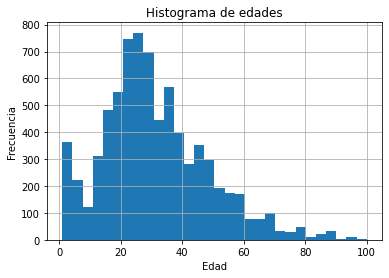

In [8]:
#Histograma
labels['real_age'].hist(bins=30)
plt.title('Histograma de edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

Se observa una distribución sesgada a la derecha, donde la mediana (29) es menor que la media (31.20). La edad más frecuente (moda) está entre 20 y 29 años.

El 75% de los datos corresponden a personas de hasta 41 años aunque se cuenta con imágenes de personas de hasta 100 años. La edad mínima es 1 año.

Se procederá a imprimir 15 imágenes con las edades correspondientes del primer lote.

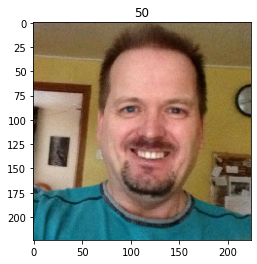

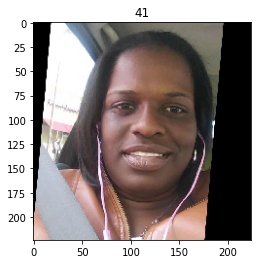

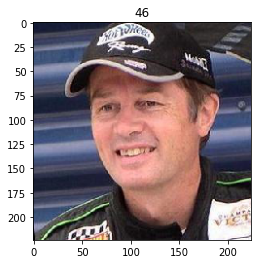

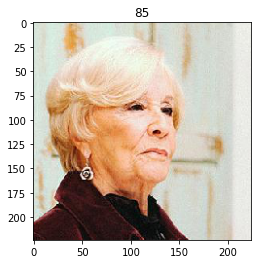

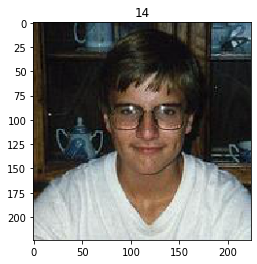

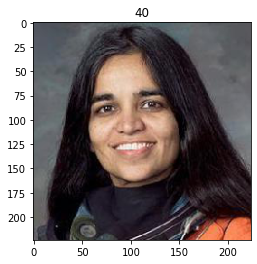

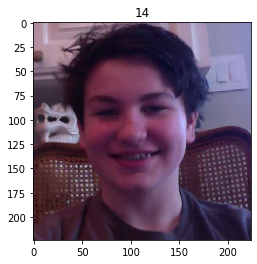

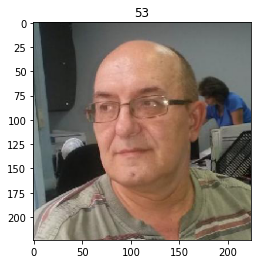

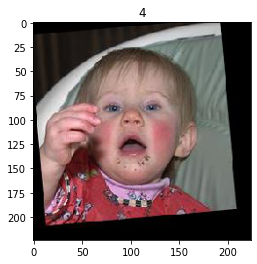

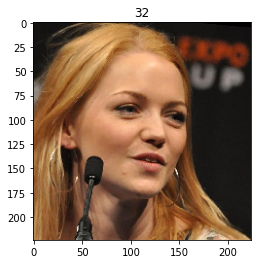

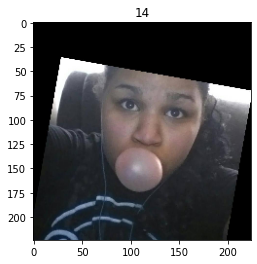

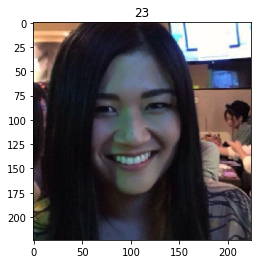

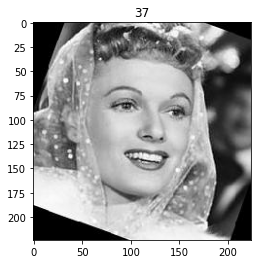

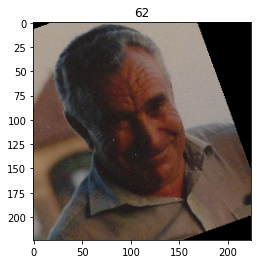

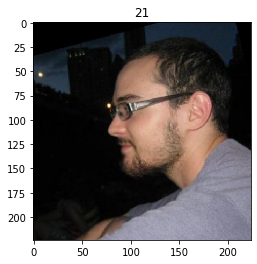

In [9]:
#La función zip empareja elementos de dos o más conjuntos
for age, img in zip(target[:15], features[:15]):
    plt.figure()
    plt.title(age)
    plt.imshow(img)

En este lote de fotografías se observa que existen personas cuyas edades están en un rango de 4 a 85 años. Además, se tienen fotografías rotadas o con fondos oscuros, de donde se puede suponer que los demás lotes son parecidos. Estas características serán muy útiles para el entrenamiento del modelo.

[Volver a Contenidos](#back)

## Etapa 3. Entrenamiento del modelo <a id='data_model'></a>

Se importarán las clases necesarias de la librería `keras`.

In [10]:
#Ya están importadas pero deben importarse para el script que se entrenará en el GPU

#import pandas as pd
#import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

### Creación de funciones <a id='data_model_functions'></a>

A continuación se crearán funciones, necesarias para el código con el que se entrenará el modelo en el GPU. Las dos primeras funciones regresarán los conjuntos de entrenamiento y prueba respectivamente. Para el conjunto de prueba se aumentaran las imágenes reflejando tanto vertical como horizontalmente. Además, el conjunto de prueba consistira del 25% del total del conjunto de datos.

In [11]:
#Función para cargar el conjunto de entrenamiento
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [12]:
#Función para cargar el conjunto de prueba
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

Al tratarse de imágenes grandes se utilizarán redes neuronales convolucionales para crear el modelo. Además, se decide utilizar la arquitectura ResNet con 50 capas pues es mejor que otras arquitecturas. La función de pérdida es el Error Cuadrado Medio y el obejtivo para evaluar la calidad del modelo será obtener un Error Absoluto Medio menor a 8 en el conjunto de prueba.

In [13]:
#Función para crear el modelo
def create_model(input_shape):
    backbone = ResNet50(
        input_shape = input_shape,
        include_top = False,
        weights = 'imagenet'
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae']
    )

    return model

In [15]:
#Función para entrenar el modelo
def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

De manera que el script para la plataforma GPU es de la siguiente manera (no ejecutar en el notebook).

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape = input_shape,
        include_top = False,
        weights = 'imagenet'
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae']
    )
    
    return model

def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=6,
    steps_per_epoch=None,
    validation_steps=None,
    ):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

#Sección de inicialización.
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

[Volver a Contenidos](#back)

### Resultados del entrenamiento <a id='data_model_train'></a>

Los resultados obtenidos de la plataforma GPU son los siguientes.

`Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 47s - loss: 270.3531 - mae: 11.9609 - val_loss: 963.7490 - val_mae: 26.2899
Epoch 2/6
178/178 - 38s - loss: 104.5749 - mae: 7.7315 - val_loss: 846.1098 - val_mae: 24.0874
Epoch 3/6
178/178 - 38s - loss: 81.1519 - mae: 6.8061 - val_loss: 231.8599 - val_mae: 11.8009
Epoch 4/6
178/178 - 38s - loss: 62.6253 - mae: 5.9901 - val_loss: 162.2955 - val_mae: 10.0902
Epoch 5/6
178/178 - 38s - loss: 53.8023 - mae: 5.5646 - val_loss: 110.2164 - val_mae: 7.8722
Epoch 6/6
178/178 - 38s - loss: 45.7567 - mae: 5.1113 - val_loss: 77.6169 - val_mae: 6.5928
60/60 - 9s - loss: 77.6169 - mae: 6.5928
Test MAE: 6.5928`

Se observa que después de 6 épocas se obtiene un Error Absoluto Medio de 6.59 en el conjunto de prueba, lo cual representa un muy buen resultado.

[Volver a Contenidos](#back)

### Conclusiones <a id='data_model_conclusions'></a>

En esta etapa se creó un script para entrenar el modelo en la plataforma GPU. Para ello se definieron cuatro funciones, las primeras dos cargaron los conjuntos de entrenamiento y prueba. Las otras dos funciones fueron para crear y entrenar el modelo.

Tras ejecutarlo en la plataforma GPU se obtuvo un EAM de 6.59 en el conjunto de prueba y después de 6 épocas. Por lo tanto, el modelo cumple el objetivo del proyecto.

[Volver a Contenidos](#back)

## Conclusión general <a id='data_conclusion'></a>

El proyecto fue realizado en tres etapas, en la primera de ellas se almacenaron los archivos de etiquetas e imágenes en dos variables. Se verificó que el dataframe de las etiquetas no contenía valores ausentes ni filas duplicadas.

En la segunda etapa se analizó la distribución de las edades de las personas en las fotografías. El rango de esta distribución es de 1 a 100 años, con la mayor frecuencia entre 20 y 29 años. La media de edad es de 31.20 años y el 75% de los datos corresponden a edades hasta los 41 años. También se imprimieron algunas imágenes del primer lote donde se observó que existían imágenes de un amplio rango de edades e incluso algunas de ellas estaban rotadas.

Finalmente, en la última etapa se construyo el modelo utilizando la arquitectura ResNet con 50 capas convolucionales y la base de datos ImageNet para la inicialización de los pesos. Este modelo se entrenó en la plataforma GPU y se obtuvo un EAM de 6.59 en el conjunto de prueba, logrando el objetivo del proyecto.

[Volver a Contenidos](#back)